# Notebook Contents

- [Imports](#Imports)
- [Data](#Data)
- [Preprocessing](#Preprocessing)
    - [Multicolinearity - VIF](#Multicolinearity---VIF)
- [Features](#Features)
- [Clustering](#Clustering)
    - [4-Seam](#4-Seam-Fastball)
    - [Cutter](#Cutter)
    - [Sinker](#Sinker)
    - [Slider](#Slider)
    - [Curveball](#Curveball)
    - [Changeup](#Changeup)
- [Linear Regression Modeling](#Linear-Regression-Modeling)
    - [4-Seam](#Linear-Regression---4-Seam)
    - [Cutter](#Linear-Regression---Cutter)
    - [Sinker](#Linear-Regression---Sinker)
    - [Slider](#Linear-Regression---Slider)
    - [Curveball](#Linear-Regression---Curveball)
    - [Changeup](#Linear-Regression---Changeup)

# Imports

In [1]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, k_means
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score

import warnings
warnings.filterwarnings('ignore')

# Data

In [2]:
data = pd.read_csv('../data/model-pitches.csv')
data.drop(columns = ['Unnamed: 0'], inplace = True) 
data.dropna(inplace = True)

pd.set_option('max_columns', None)
print(data.shape)
data.head(5)

(116889, 29)


,p_throws,pitch_type,velo,spin_rate,spin_axis,pfx_-x,pfx_z,bauer_units,effective_speed,release_pos_x,release_pos_z,release_extension,release_pos_y,plate_-x,plate_x,plate_z,swing_miss,delta_run_exp,stand,hit_distance_sc,exit_velo,launch_angle,launch_speed_angle,xba,xwobacon,woba_value,woba_denom,babip_value,iso_value
0,L,FF,92.3,2330.0,148.0,-8.28,16.56,25.243770,92.8,1.40,6.80,6.5,54.03,0.69,-0.69,2.83,0,-0.073,R,13.0,95.2,-13.0,2.0,0.174,0.158,0.0,1.0,0.0,0.0
4,L,FF,91.2,2281.0,143.0,-7.56,15.36,25.010965,90.9,1.49,6.66,6.3,54.15,0.31,-0.31,2.80,0,-0.189,L,9.0,93.3,-18.0,2.0,0.100,0.090,0.0,1.0,0.0,0.0
9,R,SI,94.3,1982.0,221.0,16.20,10.56,21.018028,94.4,-1.20,6.05,6.5,53.98,0.26,-0.26,1.78,0,-0.061,R,140.0,75.3,65.0,3.0,0.000,0.000,0.0,1.0,0.0,0.0
18,R,SL,90.5,2133.0,216.0,-0.12,7.44,23.569061,91.1,-1.51,5.93,6.3,54.23,-0.01,0.01,2.23,0,-0.173,L,294.0,96.8,18.0,4.0,0.409,0.457,0.0,1.0,0.0,0.0
27,R,FF,94.9,2224.0,216.0,9.00,14.16,23.435195,95.5,-2.71,6.38,6.6,53.86,0.10,-0.10,1.94,0,-0.163,R,308.0,91.8,29.0,3.0,0.109,0.156,0.0,1.0,0.0,0.0


In [3]:
# data['stand'] = data['stand'].map({'R': 0, 'L': 1})
# data['p_throws'] = data['p_throws'].map({'R': 0, 'L': 1})

# Drop pitch types Knuckle Curve and Splitter
# pitch = pitch[(pitch['pitch_type'] != 'KC') & (pitch['pitch_type'] != 'FS')]

Pitch Types:

4-Seam, Cutter, Sinker, Slider, Curveball, Changeup

# Preprocessing

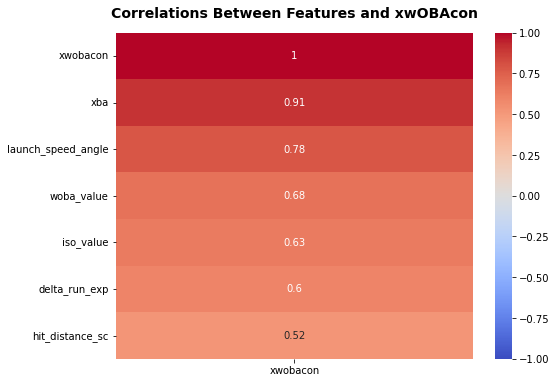

In [4]:
plt.figure(figsize = (8, 6))
sns.heatmap(data.corr()[['xwobacon']][data.corr()['xwobacon'] > .5].sort_values('xwobacon', ascending = False), 
            annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1)
plt.title('Correlations Between Features and xwOBAcon', fontsize = 14, fontweight = 'bold', pad = 15);

### Multicolinearity - VIF

In [5]:
features = data[['velo', 'release_extension', 'pfx_-x', 'pfx_z', 'spin_rate',
                 'xwobacon', 'launch_speed_angle', 'xba', 'delta_run_exp',
                 'iso_value', 'pitch_type', 'p_throws']]
features_vif = features.select_dtypes([np.number])
vif_data = pd.DataFrame()
vif_data["feature"] = features_vif.columns

vif_data["VIF"] = [variance_inflation_factor(features_vif.values, i)
                   for i in range(len(features_vif.columns))]

vif_data.sort_values(by = 'VIF').head(10)

,feature,VIF
2,pfx_-x,1.109449
8,delta_run_exp,2.385906
3,pfx_z,3.076350
9,iso_value,4.023424
6,launch_speed_angle,18.345313
7,xba,21.186838
5,xwobacon,26.194310
4,spin_rate,53.346066
1,release_extension,147.835870
0,velo,213.918076


# Features

**Independent Variables:** Velocity, Release Extension, VB, HB, Launch Speed Angle, xBA

**Dependent Variable:** xwOBAcon

In [6]:
ff = features.loc[features['pitch_type'] == 'FF']
print('4-Seam shape:', ff.shape)
ff_r = features.loc[(features['pitch_type'] == 'FF') & (features['p_throws'] == 'R')]
print('RHP 4-Seam shape:', ff_r.shape)
ff_l = ff_r = features.loc[(features['pitch_type'] == 'FF') & (features['p_throws'] == 'L')]
print('LHP 4-Seam shape:', ff_l.shape, '\n')
fc = features.loc[features['pitch_type'] == 'FC']
print('Cutter shape:', fc.shape)
fc_r = features.loc[(features['pitch_type'] == 'FC') & (features['p_throws'] == 'R')]
print('RHP Cutter shape:', fc_r.shape)
fc_l = ff_r = features.loc[(features['pitch_type'] == 'FC') & (features['p_throws'] == 'L')]
print('LHP Cutter shape:', fc_l.shape, '\n')
si = features.loc[features['pitch_type'] == 'SI']
print('Sinker shape:', si.shape)
si_r = features.loc[(features['pitch_type'] == 'SI') & (features['p_throws'] == 'R')]
print('RHP Sinker shape:', si_r.shape)
si_l = ff_r = features.loc[(features['pitch_type'] == 'SI') & (features['p_throws'] == 'L')]
print('LHP Sinker shape:', si_l.shape, '\n')
sl = features.loc[features['pitch_type'] == 'SL']
print('Slider shape:', sl.shape)
sl_r = features.loc[(features['pitch_type'] == 'SL') & (features['p_throws'] == 'R')]
print('RHP Slider shape:', sl_r.shape)
sl_l = ff_r = features.loc[(features['pitch_type'] == 'SL') & (features['p_throws'] == 'L')]
print('LHP Slider shape:', sl_l.shape, '\n')
cu = features.loc[features['pitch_type'] == 'CU']
print('Curveball shape:', cu.shape)
cu_r = features.loc[(features['pitch_type'] == 'CU') & (features['p_throws'] == 'R')]
print('RHP Curveball shape:', cu_r.shape)
cu_l = ff_r = features.loc[(features['pitch_type'] == 'CU') & (features['p_throws'] == 'L')]
print('LHP Curveball shape:', cu_l.shape, '\n')
ch = features.loc[features['pitch_type'] == 'CH']
print('Changeup shape:', ch.shape)
ch_r = features.loc[(features['pitch_type'] == 'CH') & (features['p_throws'] == 'R')]
print('RHP Changeup shape:', ch_r.shape)
ch_l = ff_r = features.loc[(features['pitch_type'] == 'CH') & (features['p_throws'] == 'L')]
print('LHP Changeup shape:', ch_l.shape)

4-Seam shape: (40378, 12)
RHP 4-Seam shape: (28478, 12)
LHP 4-Seam shape: (11900, 12) 

Cutter shape: (8698, 12)
RHP Cutter shape: (5588, 12)
LHP Cutter shape: (3110, 12) 

Sinker shape: (21979, 12)
RHP Sinker shape: (15373, 12)
LHP Sinker shape: (6606, 12) 

Slider shape: (21518, 12)
RHP Slider shape: (16153, 12)
LHP Slider shape: (5365, 12) 

Curveball shape: (8439, 12)
RHP Curveball shape: (5743, 12)
LHP Curveball shape: (2696, 12) 

Changeup shape: (15877, 12)
RHP Changeup shape: (9626, 12)
LHP Changeup shape: (6251, 12)


# Clustering

## 4-Seam

### RHP

In [7]:
features_ff_r = ff_r.select_dtypes([np.number])
X_ff_r = features_ff_r

ss = StandardScaler()
X_ff_r_scaled = ss.fit_transform(X_ff_r)
X_ff_r_scaled[:,:] *= -1

pca_ff_r = PCA().fit_transform(X_ff_r_scaled)
model_ff_r = pd.DataFrame(data = pca_ff_r, columns = X_ff_r.columns)

km_ff_r = KMeans(n_clusters = 2, 
               random_state = 1)
km_ff_r.fit(model_ff_r)
label_ff_r = km_ff_r.fit_predict(model_ff_r)

print('Number of iterations:', km_ff_r.n_iter_)
print('Number of features:', km_ff_r.n_features_in_)
print('Number of clusters:', km_ff_r.n_clusters)
print('Inertia:', km_ff_r.inertia_, '\n')
print('Predicted clusters to points: ', label_ff_r[:10])

Number of iterations: 18
Number of features: 10
Number of clusters: 2
Inertia: 47158.01381131614 

Predicted clusters to points:  [0 0 0 0 0 0 0 0 1 0]


### LHP

In [8]:
features_ff_l = ff_l.select_dtypes([np.number])
X_ff_l = features_ff_l

ss = StandardScaler()
X_ff_l_scaled = ss.fit_transform(X_ff_l)
X_ff_l_scaled[:,:] *= -1

pca_ff_l = PCA().fit_transform(X_ff_l_scaled)
model_ff_l = pd.DataFrame(data = pca_ff_l, columns = X_ff_l.columns)

km_ff_l = KMeans(n_clusters = 2, 
               random_state = 1)
km_ff_l.fit(model_ff_l)
label_ff_l = km_ff_l.fit_predict(model_ff_l)

print('Number of iterations:', km_ff_l.n_iter_)
print('Number of features:', km_ff_l.n_features_in_)
print('Number of clusters:', km_ff_l.n_clusters)
print('Inertia:', km_ff_l.inertia_, '\n')
print('Predicted clusters to points: ', label_ff_l[:10])

Number of iterations: 11
Number of features: 10
Number of clusters: 2
Inertia: 89794.39081483755 

Predicted clusters to points:  [1 1 1 1 1 1 1 1 1 0]


### Cluster Labels - RHP 4-Seam

In [9]:
X_ff_r['label'] = label_ff_r
model_ff_r['label'] = label_ff_r

X_ff_r.groupby(by = 'label').mean().T

label,0,1
velo,83.541671,83.383257
release_extension,6.235985,6.231209
pfx_-x,-13.934010,-13.700273
pfx_z,7.698587,7.767041
spin_rate,1749.138512,1729.309560
xwobacon,0.146766,0.767642
launch_speed_angle,2.366401,4.506829
xba,0.149990,0.665846
delta_run_exp,-0.157593,0.474540
iso_value,0.017548,0.543753


### Cluster Labels - LHP 4-Seam

In [10]:
X_ff_l['label'] = label_ff_l
model_ff_l['label'] = label_ff_l

X_ff_l.groupby(by = 'label').mean().T

label,0,1
velo,92.605628,92.659870
release_extension,6.285463,6.303092
pfx_-x,-7.732750,-7.233169
pfx_z,15.902705,15.740640
spin_rate,2237.236330,2236.021838
xwobacon,0.882844,0.170662
launch_speed_angle,4.732729,2.694271
xba,0.706263,0.166782
delta_run_exp,0.562635,-0.169054
iso_value,0.763937,0.016562


## Cutter

### RHP

In [11]:
features_fc_r = fc_r.select_dtypes([np.number])
X_fc_r = features_fc_r

X_fc_r_scaled = ss.fit_transform(X_fc_r)
X_fc_r_scaled[:,:] *= -1

pca_fc_r = PCA().fit_transform(X_fc_r_scaled)
model_fc_r = pd.DataFrame(data = pca_fc_r, columns = X_fc_r.columns)

km_fc_r = KMeans(n_clusters = 2, 
               random_state = 1)

km_fc_r.fit(model_fc_r)
label_fc_r = km_fc_r.fit_predict(model_fc_r)

print('Number of iterations:', km_fc_r.n_iter_)
print('Number of features:', km_fc_r.n_features_in_)
print('Number of clusters:', km_fc_r.n_clusters)
print('Inertia:', km_fc_r.inertia_, '\n')
print("Predicted clusters to points: ", label_fc_r[:10])

Number of iterations: 9
Number of features: 10
Number of clusters: 2
Inertia: 42159.729362028935 

Predicted clusters to points:  [0 0 1 0 1 1 0 0 1 1]


### LHP

In [12]:
features_fc_l = fc_l.select_dtypes([np.number])
X_fc_l = features_fc_l

X_fc_l_scaled = ss.fit_transform(X_fc_l)
X_fc_l_scaled[:,:] *= -1

pca_fc_l = PCA().fit_transform(X_fc_l_scaled)
model_fc_l = pd.DataFrame(data = pca_fc_l, columns = X_fc_l.columns)

km_fc_l = KMeans(n_clusters = 2, 
               random_state = 1)

km_fc_l.fit(model_fc_l)
label_fc_l = km_fc_r.fit_predict(model_fc_l)

print('Number of iterations:', km_fc_l.n_iter_)
print('Number of features:', km_fc_l.n_features_in_)
print('Number of clusters:', km_fc_l.n_clusters)
print('Inertia:', km_fc_l.inertia_, '\n')
print("Predicted clusters to points: ", label_fc_l[:10])

Number of iterations: 13
Number of features: 10
Number of clusters: 2
Inertia: 23481.339054031316 

Predicted clusters to points:  [1 1 0 0 0 0 1 0 1 0]


### Cluster Labels - RHP Cutter

In [13]:
X_fc_r['label'] = label_fc_r
model_fc_r['label'] = label_fc_r

X_fc_r.groupby(by = 'label').mean().T

label,0,1
velo,89.428393,89.307692
release_extension,6.298466,6.269862
pfx_-x,-2.926334,-2.699380
pfx_z,7.757098,7.871917
spin_rate,2410.682267,2406.891504
xwobacon,0.156670,0.820118
launch_speed_angle,2.497140,4.604478
xba,0.157719,0.681902
delta_run_exp,-0.179972,0.540503
iso_value,0.017161,0.647532


### Cluster Labels - LHP Cutter

In [14]:
X_fc_l['label'] = label_fc_l
model_fc_l['label'] = label_fc_l

X_fc_l.groupby(by = 'label').mean().T

label,0,1
velo,86.730780,86.704786
release_extension,6.189803,6.194705
pfx_-x,1.752857,1.369369
pfx_z,7.832820,8.166965
spin_rate,2268.210056,2263.096741
xwobacon,0.157308,0.821444
launch_speed_angle,2.520677,4.627291
xba,0.159112,0.683390
delta_run_exp,-0.163049,0.531439
iso_value,0.021617,0.664969


## Sinker

### RHP

In [15]:
features_si_r = si_r.select_dtypes([np.number])
X_si_r = features_si_r

X_si_r_scaled = ss.fit_transform(X_si_r)
X_si_r_scaled[:,:] *= -1

pca_si_r = PCA().fit_transform(X_si_r_scaled)
model_si_r = pd.DataFrame(data = pca_si_r, columns = X_si_r.columns)

km_si_r = KMeans(n_clusters = 2, 
                 random_state = 1)

km_si_r.fit(model_si_r)
label_si_r = km_si_r.fit_predict(model_si_r)

print('Number of iterations:', km_si_r.n_iter_)
print('Number of features:', km_si_r.n_features_in_)
print('Number of clusters:', km_si_r.n_clusters)
print('Inertia:', km_si_r.inertia_, '\n')
print("Predicted clusters to points: ", label_si_r[:10])

Number of iterations: 9
Number of features: 10
Number of clusters: 2
Inertia: 116402.32349688608 

Predicted clusters to points:  [0 0 0 1 0 0 1 0 0 1]


### LHP

In [16]:
features_si_l = si_l.select_dtypes([np.number])
X_si_l = features_si_l

X_si_l_scaled = ss.fit_transform(X_si_l)
X_si_l_scaled[:,:] *= -1

pca_si_l = PCA().fit_transform(X_si_l_scaled)
model_si_l = pd.DataFrame(data = pca_si_l, columns = X_si_l.columns)

km_si_l = KMeans(n_clusters = 2, 
                 random_state = 1)

km_si_l.fit(model_si_l)
label_si_l = km_si_l.fit_predict(model_si_l)

print('Number of iterations:', km_si_l.n_iter_)
print('Number of features:', km_si_l.n_features_in_)
print('Number of clusters:', km_si_l.n_clusters)
print('Inertia:', km_si_l.inertia_, '\n')
print("Predicted clusters to points: ", label_si_l[:10])

Number of iterations: 6
Number of features: 10
Number of clusters: 2
Inertia: 50164.179078079185 

Predicted clusters to points:  [1 1 1 0 1 1 0 1 0 0]


### Cluster Labels - RHP Sinker

In [17]:
X_si_r['label'] = label_si_r
model_si_r['label'] = label_si_r

X_si_r.groupby(by = 'label').mean().T

label,0,1
velo,93.456183,93.169699
release_extension,6.310052,6.289147
pfx_-x,14.893779,14.491918
pfx_z,8.733629,9.208771
spin_rate,2136.321045,2135.133145
xwobacon,0.161157,0.767463
launch_speed_angle,2.287922,4.514021
xba,0.166885,0.664980
delta_run_exp,-0.167349,0.450038
iso_value,0.014785,0.514626


### Cluster Labels - LHP Sinker

In [18]:
X_si_l['label'] = label_si_l
model_si_l['label'] = label_si_l

X_si_l.groupby(by = 'label').mean().T

label,0,1
velo,91.847472,92.063937
release_extension,6.278979,6.266443
pfx_-x,-14.756798,-15.016940
pfx_z,9.462865,8.682953
spin_rate,2067.962547,2072.866667
xwobacon,0.776448,0.161991
launch_speed_angle,4.549157,2.308054
xba,0.666597,0.167015
delta_run_exp,0.424480,-0.156515
iso_value,0.528090,0.013647


## Slider

### RHP

In [19]:
features_sl_r = sl_r.select_dtypes([np.number])
X_sl_r = features_sl_r

X_sl_r_scaled = ss.fit_transform(X_sl_r)
X_sl_r_scaled[:,:] *= -1

pca_sl_r = PCA().fit_transform(X_sl_r_scaled)
model_sl_r = pd.DataFrame(data = pca_sl_r, columns = X_sl_r.columns)

km_sl_r = KMeans(n_clusters = 2, random_state = 1)

km_sl_r.fit(model_sl_r)
label_sl_r = km_sl_r.fit_predict(model_sl_r)

print('Number of iterations:', km_sl_r.n_iter_)
print('Number of features:', km_sl_r.n_features_in_)
print('Number of clusters:', km_sl_r.n_clusters)
print('Inertia:', km_sl_r.inertia_, '\n')
print("Predicted clusters to points: ", label_sl_r[:10])

Number of iterations: 14
Number of features: 10
Number of clusters: 2
Inertia: 121363.1760263034 

Predicted clusters to points:  [0 0 1 1 1 0 0 0 0 0]


### LHP

In [20]:
features_sl_l = sl_l.select_dtypes([np.number])
X_sl_l = features_sl_l

X_sl_l_scaled = ss.fit_transform(X_sl_l)
X_sl_l_scaled[:,:] *= -1

pca_sl_l = PCA().fit_transform(X_sl_l_scaled)
model_sl_l = pd.DataFrame(data = pca_sl_l, columns = X_sl_l.columns)

km_sl_l = KMeans(n_clusters = 2, random_state = 1)

km_sl_l.fit(model_sl_l)
label_sl_l = km_sl_l.fit_predict(model_sl_l)

print('Number of iterations:', km_sl_l.n_iter_)
print('Number of features:', km_sl_l.n_features_in_)
print('Number of clusters:', km_sl_l.n_clusters)
print('Inertia:', km_sl_l.inertia_, '\n')
print("Predicted clusters to points: ", label_sl_l[:10])

Number of iterations: 18
Number of features: 10
Number of clusters: 2
Inertia: 40163.34864687215 

Predicted clusters to points:  [0 1 1 1 1 1 0 0 1 1]


### Cluster Labels - RHP Slider

In [21]:
X_sl_r['label'] = label_sl_r
model_sl_r['label'] = label_sl_r

X_sl_r.groupby(by = 'label').mean().T

label,0,1
velo,84.850092,84.828911
release_extension,6.260778,6.234443
pfx_-x,-6.179502,-5.919449
pfx_z,1.863626,1.718457
spin_rate,2427.001836,2417.358627
xwobacon,0.152922,0.827795
launch_speed_angle,2.554526,4.611912
xba,0.152408,0.686248
delta_run_exp,-0.154517,0.605313
iso_value,0.018977,0.738872


### Cluster Labels - LHP Slider

In [22]:
X_sl_l['label'] = label_sl_l
model_sl_l['label'] = label_sl_l

X_sl_l.groupby(by = 'label').mean().T

label,0,1
velo,83.873799,83.922792
release_extension,6.244266,6.230205
pfx_-x,5.124638,5.575426
pfx_z,1.488738,1.482871
spin_rate,2330.557335,2349.048633
xwobacon,0.857458,0.164253
launch_speed_angle,4.663037,2.545216
xba,0.700846,0.163954
delta_run_exp,0.641510,-0.153778
iso_value,0.756566,0.015247


## Curveball

### RHP

In [23]:
features_cu_r = cu_r.select_dtypes([np.number])
X_cu_r = features_cu_r

X_cu_r_scaled = ss.fit_transform(X_cu_r)
X_cu_r_scaled[:,:] *= -1

pca_cu_r = PCA().fit_transform(X_cu_r_scaled)
model_cu_r = pd.DataFrame(data = pca_cu_r, columns = X_cu_r.columns)

km_cu_r = KMeans(n_clusters = 2, random_state = 1)

km_cu_r.fit(model_cu_r)
label_cu_r = km_cu_r.fit_predict(model_cu_r)

print('Number of iterations:', km_cu_r.n_iter_)
print('Number of features:', km_cu_r.n_features_in_)
print('Number of clusters:', km_cu_r.n_clusters)
print('Inertia:', km_cu_r.inertia_, '\n')
print("Predicted clusters to points: ", label_cu_r[:10])

Number of iterations: 7
Number of features: 10
Number of clusters: 2
Inertia: 43755.07095704863 

Predicted clusters to points:  [1 0 0 0 1 1 0 1 0 0]


### LHP

In [24]:
features_cu_l = cu_l.select_dtypes([np.number])
X_cu_l = features_cu_l

X_cu_l_scaled = ss.fit_transform(X_cu_l)
X_cu_l_scaled[:,:] *= -1

pca_cu_l = PCA().fit_transform(X_cu_l_scaled)
model_cu_l = pd.DataFrame(data = pca_cu_l, columns = X_cu_l.columns)

km_cu_l = KMeans(n_clusters = 2, random_state = 1)

km_cu_l.fit(model_cu_l)
label_cu_l = km_cu_l.fit_predict(model_cu_l)

print('Number of iterations:', km_cu_l.n_iter_)
print('Number of features:', km_cu_l.n_features_in_)
print('Number of clusters:', km_cu_l.n_clusters)
print('Inertia:', km_cu_l.inertia_, '\n')
print("Predicted clusters to points: ", label_cu_l[:10])

Number of iterations: 11
Number of features: 10
Number of clusters: 2
Inertia: 20378.305735671933 

Predicted clusters to points:  [0 1 0 1 0 0 1 0 0 0]


### Cluster Labels - RHP Curveball

In [25]:
X_cu_r['label'] = label_cu_r
model_cu_r['label'] = label_cu_r

X_cu_r.groupby(by = 'label').mean().T

label,0,1
velo,78.956187,79.064254
release_extension,6.219574,6.242217
pfx_-x,-9.573773,-9.796404
pfx_z,-9.463753,-9.282387
spin_rate,2527.156694,2538.449218
xwobacon,0.761993,0.148242
launch_speed_angle,4.483266,2.459560
xba,0.660586,0.148583
delta_run_exp,0.474966,-0.140501
iso_value,0.563895,0.021215


### Cluster Labels - LHP Curveball

In [26]:
X_cu_l['label'] = label_cu_l
model_cu_l['label'] = label_cu_l

X_cu_l.groupby(by = 'label').mean().T

label,0,1
velo,77.578066,77.511851
release_extension,6.105635,6.117156
pfx_-x,8.715978,7.907404
pfx_z,-7.152597,-7.317968
spin_rate,2439.197790,2392.110609
xwobacon,0.151405,0.786795
launch_speed_angle,2.458564,4.503386
xba,0.152844,0.677102
delta_run_exp,-0.131293,0.525246
iso_value,0.022099,0.588036


## Changeup

### RHP

In [27]:
features_ch_r = ch_r.select_dtypes([np.number])
X_ch_r = features_ch_r

X_ch_r_scaled = ss.fit_transform(X_ch_r)
X_ch_r_scaled[:,:] *= -1

pca_ch_r = PCA().fit_transform(X_ch_r)
model_ch_r = pd.DataFrame(data = pca_ch_r, columns = X_ch_r.columns)

km_ch_r = KMeans(n_clusters = 2, random_state = 1)

km_ch_r.fit(model_ch_r)
label_ch_r = km_ch_r.fit_predict(model_ch_r)

print('Number of iterations:', km_ch_r.n_iter_)
print('Number of features:', km_ch_r.n_features_in_)
print('Number of clusters:', km_ch_r.n_clusters)
print('Inertia:', km_ch_r.inertia_, '\n')
print("Predicted clusters to points: ", label_ch_r[:10])

Number of iterations: 12
Number of features: 10
Number of clusters: 2
Inertia: 305108032.731053 

Predicted clusters to points:  [0 0 1 0 0 0 0 1 1 1]


### LHP

In [28]:
features_ch_l = ch_l.select_dtypes([np.number])
X_ch_l = features_ch_l

X_ch_l_scaled = ss.fit_transform(X_ch_l)
X_ch_l_scaled[:,:] *= -1

pca_ch_l = PCA().fit_transform(X_ch_l)
model_ch_l = pd.DataFrame(data = pca_ch_l, columns = X_ch_l.columns)

km_ch_l = KMeans(n_clusters = 2, random_state = 1)

km_ch_l.fit(model_ch_l)
label_ch_l = km_ch_l.fit_predict(model_ch_l)

print('Number of iterations:', km_ch_l.n_iter_)
print('Number of features:', km_ch_l.n_features_in_)
print('Number of clusters:', km_ch_l.n_clusters)
print('Inertia:', km_ch_l.inertia_, '\n')
print("Predicted clusters to points: ", label_ch_l[:10])

Number of iterations: 7
Number of features: 10
Number of clusters: 2
Inertia: 185501107.4845686 

Predicted clusters to points:  [0 0 0 0 0 0 0 0 0 0]


### Cluster Labels - RHP Changeup

In [29]:
X_ch_r['label'] = label_ch_r
model_ch_r['label'] = label_ch_r

X_ch_r.groupby(by = 'label').mean().T

label,0,1
velo,85.149284,85.834064
release_extension,6.392187,6.224641
pfx_-x,12.803260,14.922389
pfx_z,6.378540,6.441119
spin_rate,1555.284073,2022.840766
xwobacon,0.348556,0.341388
launch_speed_angle,3.058688,3.045855
xba,0.313763,0.311517
delta_run_exp,0.048104,0.041617
iso_value,0.215839,0.189720


### Cluster Labels - LHP Changeup

In [30]:
X_ch_l['label'] = label_ch_l
model_ch_l['label'] = label_ch_l

X_ch_l.groupby(by = 'label').mean().T

label,0,1
velo,83.287550,83.846167
release_extension,6.270766,6.171397
pfx_-x,-12.877167,-15.568463
pfx_z,7.177802,8.663022
spin_rate,1561.290827,2058.458607
xwobacon,0.351041,0.329382
launch_speed_angle,3.038306,3.052124
xba,0.321084,0.299332
delta_run_exp,0.048103,0.032300
iso_value,0.178679,0.193167


# Linear Regression Modeling

## Linear Regression - 4-Seam

### RHP

In [31]:
X = X_ff_r.drop(columns = ['xwobacon'])
X = sm.add_constant(X)
y = X_ff_r['xwobacon']

ols_ff_r = sm.OLS(y, X).fit()
pred_ff_r = ols_ff_r.predict(X)
fitted_vals_ff_r = ols_ff_r.fittedvalues
residuals_ff_r = ols_ff_r.resid

print('MSE:', round(metrics.mean_squared_error(y, pred_ff_r), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_ff_r)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_ff_r), 4))
print(ols_ff_r.summary())

MSE: 0.0082
RMSE: 0.0907
MAE: 0.0532
                            OLS Regression Results                            
Dep. Variable:               xwobacon   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     9364.
Date:                Tue, 01 Mar 2022   Prob (F-statistic):               0.00
Time:                        19:39:56   Log-Likelihood:                 6132.6
No. Observations:                6251   AIC:                        -1.224e+04
Df Residuals:                    6240   BIC:                        -1.217e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

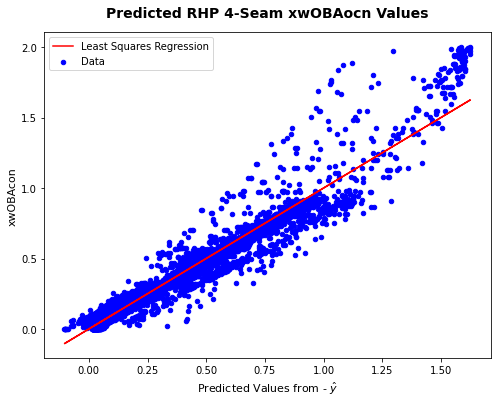

In [32]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_ff_r, y, s = 20, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_ff_r, np.poly1d(np.polyfit(pred_ff_r, y, 1))(pred_ff_r), c = 'r',label = 'Least Squares Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('xwOBAcon', fontsize = 11)
plt.title('Predicted RHP 4-Seam xwOBAocn Values', fontsize = 14, fontweight = 'bold', pad = 15);

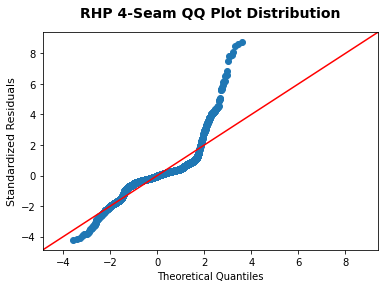

In [33]:
sm.qqplot(residuals_ff_r, line = '45', fit = True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('RHP 4-Seam QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP

In [34]:
X = X_ff_l.drop(columns = ['xwobacon'])
X = sm.add_constant(X)
y = X_ff_l['xwobacon']

ols_ff_l = sm.OLS(y, X).fit()
pred_ff_l = ols_ff_l.predict(X)
fitted_vals_ff_l = ols_ff_l.fittedvalues
residuals_ff_l = ols_ff_l.resid

print('MSE:', round(metrics.mean_squared_error(y, pred_ff_l), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_ff_l)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_ff_l), 4))
print(ols_ff_l.summary())

MSE: 0.0118
RMSE: 0.1085
MAE: 0.0674
                            OLS Regression Results                            
Dep. Variable:               xwobacon   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                 1.684e+04
Date:                Tue, 01 Mar 2022   Prob (F-statistic):               0.00
Time:                        19:39:57   Log-Likelihood:                 9547.1
No. Observations:               11900   AIC:                        -1.907e+04
Df Residuals:                   11889   BIC:                        -1.899e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

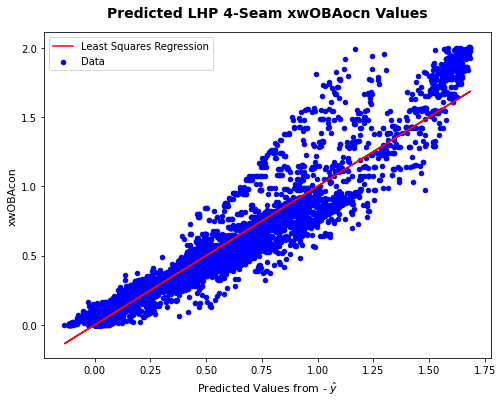

In [35]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_ff_l, y, s = 20, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_ff_l, np.poly1d(np.polyfit(pred_ff_l, y, 1))(pred_ff_l), c = 'r',label = 'Least Squares Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('xwOBAcon', fontsize = 11)
plt.title('Predicted LHP 4-Seam xwOBAocn Values', fontsize = 14, fontweight = 'bold', pad = 15);

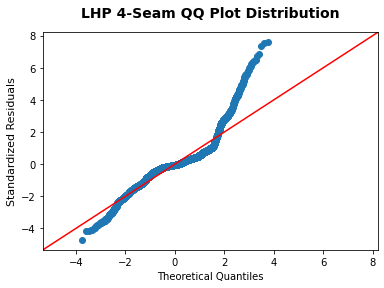

In [36]:
sm.qqplot(residuals_ff_l, line = '45', fit = True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('LHP 4-Seam QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

## Linear Regression - Cutter

### RHP

In [37]:
X = X_fc_r.drop(columns = ['xwobacon'])
X = sm.add_constant(X)
y = X_fc_r['xwobacon']

ols_fc_r = sm.OLS(y, X).fit()
pred_fc_r = ols_fc_r.predict(X)
fitted_vals_fc_r = ols_fc_r.fittedvalues
residuals_fc_r = ols_fc_r.resid

print('MSE:', round(metrics.mean_squared_error(y, pred_fc_r), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_fc_r)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_fc_r), 4))
print(ols_fc_r.summary())

MSE: 0.0103
RMSE: 0.1015
MAE: 0.0619
                            OLS Regression Results                            
Dep. Variable:               xwobacon   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     7718.
Date:                Tue, 01 Mar 2022   Prob (F-statistic):               0.00
Time:                        19:39:57   Log-Likelihood:                 4855.2
No. Observations:                5588   AIC:                            -9688.
Df Residuals:                    5577   BIC:                            -9615.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

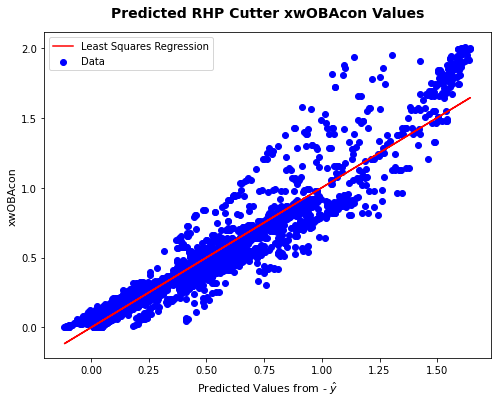

In [38]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_fc_r, y, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_fc_r, np.poly1d(np.polyfit(pred_fc_r, y, 1))(pred_fc_r), c = 'r',label = 'Least Squares Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('xwOBAcon', fontsize = 11)
plt.title('Predicted RHP Cutter xwOBAcon Values', fontsize = 14, fontweight = 'bold', pad = 15);

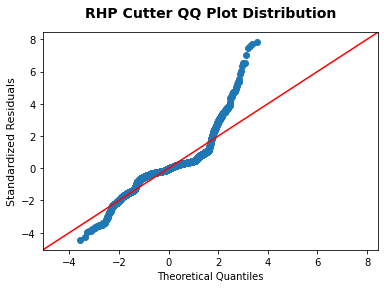

In [39]:
sm.qqplot(residuals_fc_r, line = '45', fit = True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('RHP Cutter QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP

In [40]:
X = X_fc_l.drop(columns = ['xwobacon'])
X = sm.add_constant(X)
y = X_fc_l['xwobacon']

ols_fc_l = sm.OLS(y, X).fit()
pred_fc_l = ols_fc_l.predict(X)
fitted_vals_fc_l = ols_fc_l.fittedvalues
residuals_fc_l = ols_fc_l.resid

print('MSE:', round(metrics.mean_squared_error(y, pred_fc_l), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_fc_l)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_fc_l), 4))
print(ols_fc_l.summary())

MSE: 0.0105
RMSE: 0.1024
MAE: 0.0619
                            OLS Regression Results                            
Dep. Variable:               xwobacon   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     4244.
Date:                Tue, 01 Mar 2022   Prob (F-statistic):               0.00
Time:                        19:39:57   Log-Likelihood:                 2675.3
No. Observations:                3110   AIC:                            -5329.
Df Residuals:                    3099   BIC:                            -5262.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

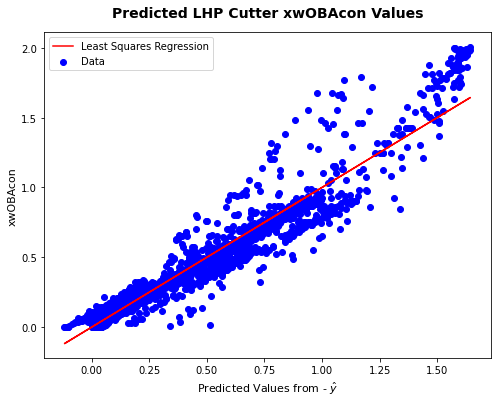

In [41]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_fc_l, y, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_fc_l, np.poly1d(np.polyfit(pred_fc_l, y, 1))(pred_fc_l), c = 'r',label = 'Least Squares Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('xwOBAcon', fontsize = 11)
plt.title('Predicted LHP Cutter xwOBAcon Values', fontsize = 14, fontweight = 'bold', pad = 15);

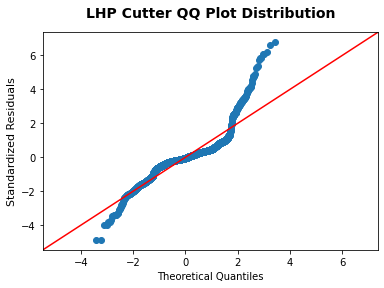

In [42]:
sm.qqplot(residuals_fc_l, line = '45', fit = True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('LHP Cutter QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

## Linear Regression - Sinker

### RHP

In [43]:
X = X_si_r.drop(columns = ['xwobacon'])
X = sm.add_constant(X)
y = X_si_r['xwobacon']

ols_si_r = sm.OLS(y, X).fit()
pred_si_r = ols_si_r.predict(X)
fitted_vals_si_r = ols_si_r.fittedvalues
residuals_si_r = ols_si_r.resid

print('MSE:', round(metrics.mean_squared_error(y, pred_si_r), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_si_r)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_si_r), 4))
print(ols_si_r.summary())

MSE: 0.0083
RMSE: 0.0909
MAE: 0.0521
                            OLS Regression Results                            
Dep. Variable:               xwobacon   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                 2.275e+04
Date:                Tue, 01 Mar 2022   Prob (F-statistic):               0.00
Time:                        19:39:57   Log-Likelihood:                 15055.
No. Observations:               15373   AIC:                        -3.009e+04
Df Residuals:                   15362   BIC:                        -3.000e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

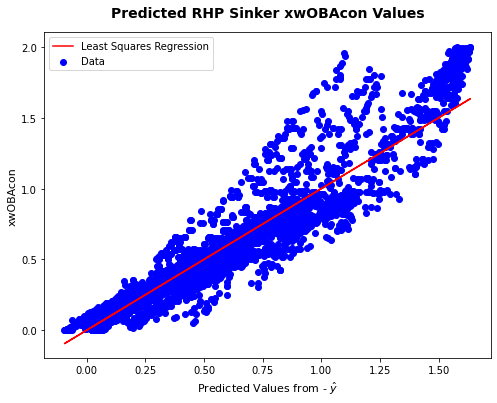

In [44]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_si_r, y, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_si_r, np.poly1d(np.polyfit(pred_si_r, y, 1))(pred_si_r), c = 'r',label = 'Least Squares Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('xwOBAcon', fontsize = 11)
plt.title('Predicted RHP Sinker xwOBAcon Values', fontsize = 14, fontweight = 'bold', pad = 15);

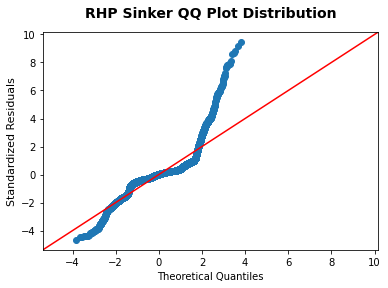

In [45]:
sm.qqplot(residuals_si_r, line = '45', fit = True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('RHP Sinker QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP

In [46]:
X = X_si_l.drop(columns = ['xwobacon'])
X = sm.add_constant(X)
y = X_si_l['xwobacon']

ols_si_l = sm.OLS(y, X).fit()
pred_si_l = ols_si_l.predict(X)
fitted_vals_si_l = ols_si_l.fittedvalues
residuals_si_l = ols_si_l.resid

print('MSE:', round(metrics.mean_squared_error(y, pred_si_l), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_si_l)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_si_l), 4))
print(ols_si_l.summary())

MSE: 0.0091
RMSE: 0.0953
MAE: 0.0552
                            OLS Regression Results                            
Dep. Variable:               xwobacon   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     9149.
Date:                Tue, 01 Mar 2022   Prob (F-statistic):               0.00
Time:                        19:39:58   Log-Likelihood:                 6155.9
No. Observations:                6606   AIC:                        -1.229e+04
Df Residuals:                    6595   BIC:                        -1.221e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

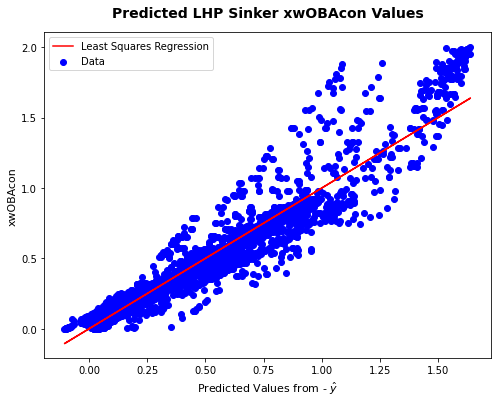

In [47]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_si_l, y, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_si_l, np.poly1d(np.polyfit(pred_si_l, y, 1))(pred_si_l), c = 'r',label = 'Least Squares Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('xwOBAcon', fontsize = 11)
plt.title('Predicted LHP Sinker xwOBAcon Values', fontsize = 14, fontweight = 'bold', pad = 15);

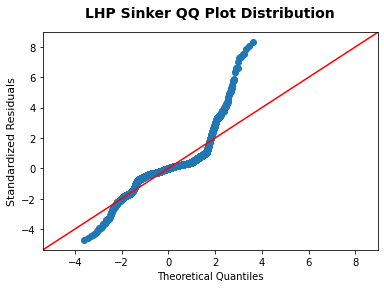

In [48]:
sm.qqplot(residuals_si_l, line = '45', fit = True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('LHP Sinker QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

## Linear Regression - Slider

### RHP

In [49]:
X = X_sl_r.drop(columns = ['xwobacon'])
X = sm.add_constant(X)
y = X_sl_r['xwobacon']

ols_sl_r = sm.OLS(y, X).fit()
pred_sl_r = ols_sl_r.predict(X)
fitted_vals_sl_r = ols_sl_r.fittedvalues
residuals_sl_r = ols_sl_r.resid

print('MSE:', round(metrics.mean_squared_error(y, pred_sl_r), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_sl_r)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_sl_r), 4))
print(ols_sl_r.summary())

MSE: 0.0104
RMSE: 0.1021
MAE: 0.0615
                            OLS Regression Results                            
Dep. Variable:               xwobacon   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                 2.165e+04
Date:                Tue, 01 Mar 2022   Prob (F-statistic):               0.00
Time:                        19:39:58   Log-Likelihood:                 13937.
No. Observations:               16153   AIC:                        -2.785e+04
Df Residuals:                   16142   BIC:                        -2.777e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

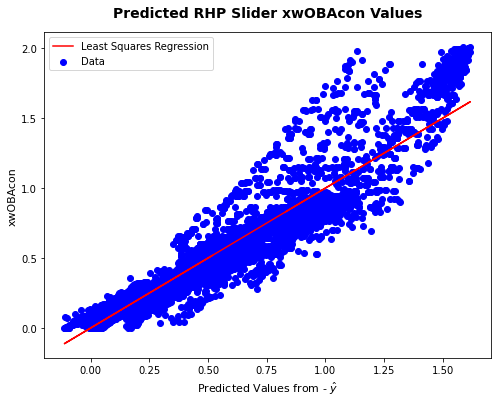

In [50]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_sl_r, y, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_sl_r, np.poly1d(np.polyfit(pred_sl_r, y, 1))(pred_sl_r), c = 'r',label = 'Least Squares Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('xwOBAcon', fontsize = 11)
plt.title('Predicted RHP Slider xwOBAcon Values', fontsize = 14, fontweight = 'bold', pad = 15);

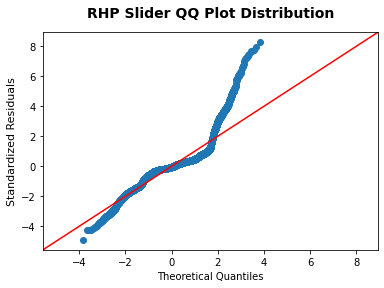

In [51]:
sm.qqplot(residuals_sl_r, line = '45', fit = True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('RHP Slider QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP

In [52]:
X = X_sl_l.drop(columns = ['xwobacon'])
X = sm.add_constant(X)
y = X_sl_l['xwobacon']

ols_sl_l = sm.OLS(y, X).fit()
pred_sl_l = ols_sl_l.predict(X)
fitted_vals_sl_l = ols_sl_l.fittedvalues
residuals_sl_l = ols_sl_l.resid

print('MSE:', round(metrics.mean_squared_error(y, pred_sl_l), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_sl_l)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_sl_l), 4))
print(ols_sl_l.summary())

MSE: 0.0113
RMSE: 0.1063
MAE: 0.0648
                            OLS Regression Results                            
Dep. Variable:               xwobacon   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     6955.
Date:                Tue, 01 Mar 2022   Prob (F-statistic):               0.00
Time:                        19:39:59   Log-Likelihood:                 4413.4
No. Observations:                5365   AIC:                            -8805.
Df Residuals:                    5354   BIC:                            -8732.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

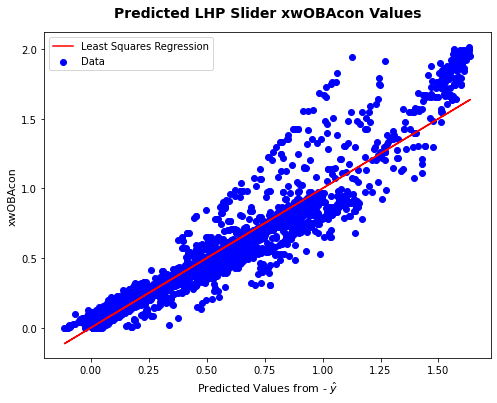

In [53]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_sl_l, y, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_sl_l, np.poly1d(np.polyfit(pred_sl_l, y, 1))(pred_sl_l), c = 'r',label = 'Least Squares Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('xwOBAcon', fontsize = 11)
plt.title('Predicted LHP Slider xwOBAcon Values', fontsize = 14, fontweight = 'bold', pad = 15);

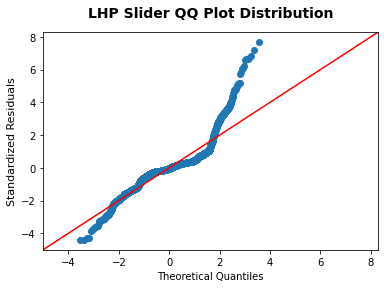

In [54]:
sm.qqplot(residuals_sl_l, line = '45', fit = True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('LHP Slider QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

## Linear Regression - Curveball

### RHP

In [55]:
X = X_cu_r.drop(columns = ['xwobacon'])
X = sm.add_constant(X)
y = X_cu_r['xwobacon']

ols_cu_r = sm.OLS(y, X).fit()
pred_cu_r = ols_cu_r.predict(X)
fitted_vals_cu_r = ols_cu_r.fittedvalues
residuals_cu_r = ols_cu_r.resid

print('MSE:', round(metrics.mean_squared_error(y, pred_cu_r), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_cu_r)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_cu_r), 4))
print(ols_cu_r.summary())

MSE: 0.0096
RMSE: 0.0978
MAE: 0.0596
                            OLS Regression Results                            
Dep. Variable:               xwobacon   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     7621.
Date:                Tue, 01 Mar 2022   Prob (F-statistic):               0.00
Time:                        19:39:59   Log-Likelihood:                 5203.3
No. Observations:                5743   AIC:                        -1.038e+04
Df Residuals:                    5732   BIC:                        -1.031e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

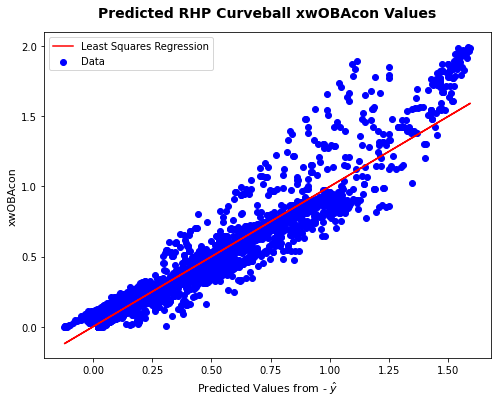

In [56]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_cu_r, y, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_cu_r, np.poly1d(np.polyfit(pred_cu_r, y, 1))(pred_cu_r), c = 'r',label = 'Least Squares Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('xwOBAcon', fontsize = 11)
plt.title('Predicted RHP Curveball xwOBAcon Values', fontsize = 14, fontweight = 'bold', pad = 15);

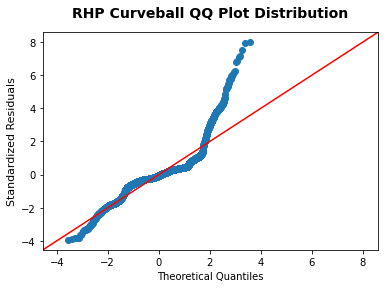

In [57]:
sm.qqplot(residuals_cu_r, line='45', fit=True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('RHP Curveball QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP

In [58]:
X = X_cu_l.drop(columns = ['xwobacon'])
X = sm.add_constant(X)
y = X_cu_l['xwobacon']

ols_cu_l = sm.OLS(y, X).fit()
pred_cu_l = ols_cu_l.predict(X)
fitted_vals_cu_l = ols_cu_l.fittedvalues
residuals_cu_l = ols_cu_l.resid

print('MSE:', round(metrics.mean_squared_error(y, pred_cu_l), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_cu_l)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_cu_l), 4))
print(ols_cu_l.summary())

MSE: 0.0094
RMSE: 0.097
MAE: 0.0586
                            OLS Regression Results                            
Dep. Variable:               xwobacon   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     3755.
Date:                Tue, 01 Mar 2022   Prob (F-statistic):               0.00
Time:                        19:39:59   Log-Likelihood:                 2464.4
No. Observations:                2696   AIC:                            -4907.
Df Residuals:                    2685   BIC:                            -4842.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------


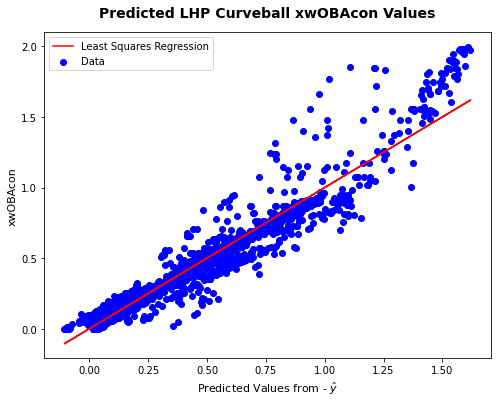

In [59]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_cu_l, y, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_cu_l, np.poly1d(np.polyfit(pred_cu_l, y, 1))(pred_cu_l), c = 'r',label = 'Least Squares Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('xwOBAcon', fontsize = 11)
plt.title('Predicted LHP Curveball xwOBAcon Values', fontsize = 14, fontweight = 'bold', pad = 15);

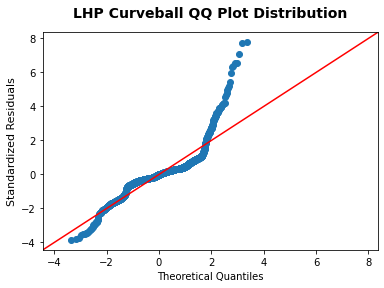

In [60]:
sm.qqplot(residuals_cu_l, line='45', fit=True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('LHP Curveball QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

## Linear Regression - Changeup

### RHP

In [61]:
X = X_ch_r.drop(columns = ['xwobacon'])
X = sm.add_constant(X)
y = X_ch_r['xwobacon']

ols_ch_r = sm.OLS(y, X).fit()
pred_ch_r = ols_ch_r.predict(X)
fitted_vals_ch_r = ols_ch_r.fittedvalues
residuals_ch_r = ols_ch_r.resid

print('MSE:', round(metrics.mean_squared_error(y, pred_ch_r), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_ch_r)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_ch_r), 4))
print(ols_ch_r.summary())

MSE: 0.0096
RMSE: 0.0977
MAE: 0.0566
                            OLS Regression Results                            
Dep. Variable:               xwobacon   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                 1.277e+04
Date:                Tue, 01 Mar 2022   Prob (F-statistic):               0.00
Time:                        19:39:59   Log-Likelihood:                 8726.5
No. Observations:                9626   AIC:                        -1.743e+04
Df Residuals:                    9615   BIC:                        -1.735e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

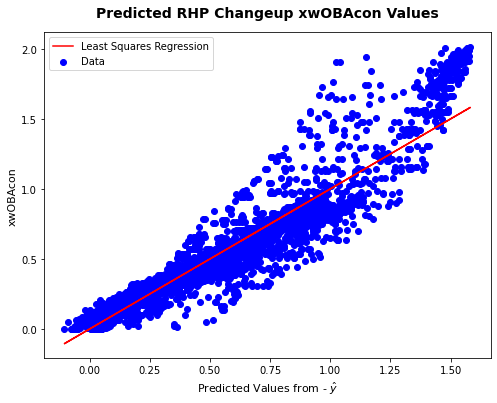

In [62]:
plt.figure(figsize = (8, 6))
plt.scatter(pred_ch_r, y, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_ch_r, np.poly1d(np.polyfit(pred_ch_r, y, 1))(pred_ch_r), c = 'r',label = 'Least Squares Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('xwOBAcon', fontsize = 11)
plt.title('Predicted RHP Changeup xwOBAcon Values', fontsize = 14, fontweight = 'bold', pad = 15);

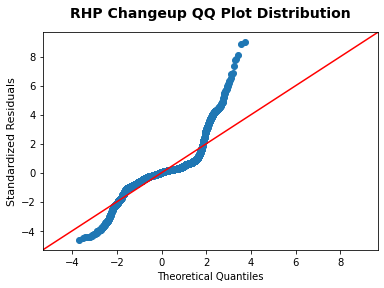

In [63]:
sm.qqplot(residuals_ch_r, line = '45', fit = True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('RHP Changeup QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP

In [64]:
X = X_ch_l.drop(columns = ['xwobacon'])
X = sm.add_constant(X)
y = X_ch_l['xwobacon']

ols_ch_l = sm.OLS(y, X).fit()
pred_ch_l = ols_ch_l.predict(X)
fitted_vals_ch_l = ols_ch_l.fittedvalues
residuals_ch_l = ols_ch_l.resid

print('MSE:', round(metrics.mean_squared_error(y, pred_ch_l), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_ch_l)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_ch_l), 4))
print(ols_ch_l.summary())

MSE: 0.0088
RMSE: 0.094
MAE: 0.0537
                            OLS Regression Results                            
Dep. Variable:               xwobacon   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     8683.
Date:                Tue, 01 Mar 2022   Prob (F-statistic):               0.00
Time:                        19:40:00   Log-Likelihood:                 5911.9
No. Observations:                6251   AIC:                        -1.180e+04
Df Residuals:                    6240   BIC:                        -1.173e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------


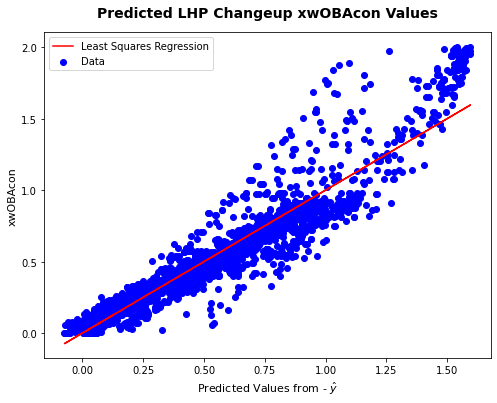

In [65]:
plt.figure(figsize = (8, 6))
plt.scatter(pred_ch_l, y, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_ch_l, np.poly1d(np.polyfit(pred_ch_l, y, 1))(pred_ch_l), c = 'r',label = 'Least Squares Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('xwOBAcon', fontsize = 11)
plt.title('Predicted LHP Changeup xwOBAcon Values', fontsize = 14, fontweight = 'bold', pad = 15);

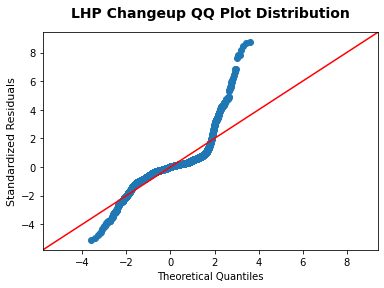

In [66]:
sm.qqplot(residuals_ch_l, line = '45', fit = True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('LHP Changeup QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);